In [1]:
%matplotlib inline 

from __future__ import division

import sys
if '../' not in sys.path: sys.path.append("../")

import numpy as np
import amnet
import control 

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

def make_vgc(e, edot, alpha):
    assert e.outdim == 1
    assert edot.outdim == 1
    
    zero1 = amnet.Constant(np.zeros(1))
    ae    = amnet.AffineTransformation(np.array([[alpha]]), e, np.zeros(1))
    neg_e = amnet.AffineTransformation(np.array([[-1]]), e, np.zeros(1))
    neg_edot = amnet.AffineTransformation(np.array([[-1]]), edot, np.zeros(1))

    return amnet.atoms.make_or(
        amnet.atoms.make_or(
            zero1,
            ae,
            neg_e,
            neg_edot
        ),
        ae,
        e,
        edot
    )

def make_vgc_system(xsys, alpha=7.0, dt=0.001, ref=1.0):
    # get PC linear system data
    #A, B, C, D = control.ssdata(control.sample_system(P_tf * C_tf, Ts=dt, method='zoh'))
    A = np.genfromtxt('vgc_A.csv', delimiter=',').reshape((6,6))
    B = np.genfromtxt('vgc_B.csv', delimiter=',').reshape((6,1))
    C = np.genfromtxt('vgc_C.csv', delimiter=',').reshape((1,6))
    D = np.genfromtxt('vgc_D.csv', delimiter=',').reshape((1,1))
    
    # state is xsys = (x_vgc, x_L)
    n_L, m_L = B.shape
    n = n_L + 1
    assert m_L == 1
    assert D == 0
    
    # pick out components
    x_vgc = amnet.AffineTransformation(np.eye(1,n,0), xsys, np.zeros(1))
    x_L   = amnet.AffineTransformation(np.eye(n-1,n,1), xsys, np.zeros(n-1))
    e     = amnet.AffineTransformation(-C, x_L, np.array([ref]))
    #edot  = e - x_vgc
    edot  = amnet.AffineTransformation(
        -np.dot(C, np.eye(n-1,n,1)) - np.eye(1,n,0),
        xsys,
        np.array([ref])
    )
    
    # compute combined control input
    vgc_term = make_vgc(e, edot, alpha)
    e_vgc = amnet.atoms.make_add(vgc_term, e)
    
    # compute next state
    Ax_L = amnet.AffineTransformation(A, x_L, np.zeros(n-1))
    Be_vgc = amnet.AffineTransformation(B, e_vgc, np.zeros(n-1))
    
    x_vgc_next = e
    x_L_next = amnet.atoms.make_add(Ax_L, Be_vgc)
    
    # generate the AMN for computing the full state
    x_next = amnet.Stack(x_vgc_next, x_L_next)
    return x_next

def make_vgc_output(xsys, ref):
    # get PC linear system data
    #A, B, C, D = control.ssdata(control.sample_system(P_tf * C_tf, Ts=dt, method='zoh'))
    A = np.genfromtxt('vgc_A.csv', delimiter=',').reshape((6,6))
    B = np.genfromtxt('vgc_B.csv', delimiter=',').reshape((6,1))
    C = np.genfromtxt('vgc_C.csv', delimiter=',').reshape((1,6))
    D = np.genfromtxt('vgc_D.csv', delimiter=',').reshape((1,1))
    
    # state is xsys = (x_vgc, x_L)
    n_L, m_L = B.shape
    n = n_L + 1
    assert m_L == 1
    assert D == 0
    
    # picks out the error signal
    return amnet.AffineTransformation(
        -np.dot(C, np.eye(n-1,n,1)),
        xsys,
        np.array([ref])
    )

In [7]:
# simulate system
alpha = 7.0
dt = 0.001
ref = 1.0
n = 7
tr = 0.23 # computed by me
#tr = 0.28 # Hunnekens, et al. (2016)
p = 1.0
yos_min = ((p*tr - 1.)*np.exp(p*tr) + 1.)/(p*tr)

# create VGC function
xsys = amnet.Variable(n, 'xsys')
phi = make_vgc_system(xsys, alpha=alpha, dt=dt, ref=ref)
phi_out = make_vgc_output(xsys, ref=ref)

t_hist = np.arange(0, 5, dt)
x_hist = np.zeros((n, len(t_hist)))
x_hist[:,0] = np.zeros((n,)) # initial condition

for i, t in enumerate(t_hist[:-1]):
    x_hist[:,i+1] = phi.eval(x_hist[:,i]).reshape((n,))

y_hist = np.array([phi_out.eval(x_hist[:,i].reshape((n,))) for i in range(len(t_hist))])

(0, 1.6)

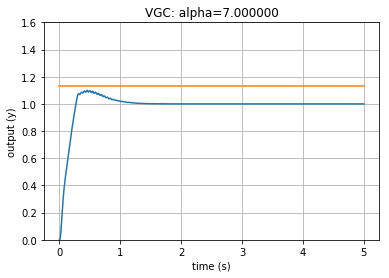

In [10]:
# plot output
plt.plot(t_hist, 1 - y_hist)
plt.plot([0, t_hist[-1]], [1 + yos_min, 1 + yos_min])
plt.xlabel('time (s)')
plt.ylabel('output (y)')
plt.title('VGC: alpha=%f' % alpha)
plt.grid(True)
axes = plt.gca()
axes.set_ylim([0, 1.6])